In [ ]:
import PIL.Image
from PIL import Image, ImageTk
from typing import Tuple
from tkinter import *
import cv2

In [55]:
%reload_ext main
from main import *

scale = 1
stride = 4
margin = 40

video = cv2.VideoCapture("videos/basketball_1.mp4")

_, first_frame = video.read()
first_frame = preprocess_frame(first_frame, scale=scale)
while True:
    selected_box = SelectBoxWindow.show_and_get_box(first_frame)
    if selected_box[-1] != 0 and selected_box[-2] != 0:
        break
print(selected_box)
tracker = ObjectTracker(first_frame, selected_box, stride=stride, margin=margin)
show_tracking_animation(video, tracker, scale=scale)

(720, 1280, 3)
(372, 280, 76, 219)


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import cv2


v = "videos/billiard_3.mp4"

cap = cv2.VideoCapture(v)
# take first frame of the video
ret, old_frame = cap.read()
old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2RGB)
# setup initial location of window
x, y, w, h = (194, 321, 47, 39)  # simply hardcoded the values
track_window = (x, y, w, h)
# set up the ROI for tracking
roi = old_frame[y : y + h, x : x + w]

plt.imshow(old_frame)
plt.show()

padding = 30
# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1)
while 1:
    ret, frame = cap.read()
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if ret == True:

        # mse(x - y) -> 0.0
        # 1 / mse(x - y)
        #

        dst = np.abs(
            cv2.cvtColor(old_frame, cv2.COLOR_RGB2HSV)[..., 0]
            - cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)[..., 0]
        )
        part = np.array(
            dst[y - padding : y + h + padding, x - padding : x + w + padding]
        )
        dst[...] = 0
        dst[y - padding : y + h + padding, x - padding : x + w + padding] = 1 / (
            part + 1e-6
        )

        # plt.imshow(dst, 'gray')
        # plt.show()
        # break
        # apply meanshift to get the new location
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        print(frame.shape, dst.shape)
        # Draw it on image
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.imshow("img2", img2)
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break
    else:
        break
    old_frame = frame

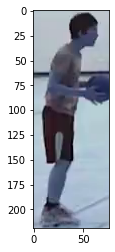

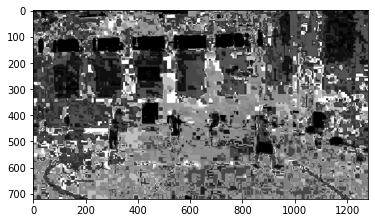

In [58]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

v = "videos/basketball_1.mp4"

video = cv2.VideoCapture(v)
_, first_frame = video.read()
x, y, w, h = (202, 327, 24, 24)
y, x, w, h = (372, 280, 76, 219)
roi = first_frame[y: y + h, x: x + w]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0, 180])
roi_hist = cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

plt.imshow(roi)
plt.show()
term_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 1)
while 1:
    ret, frame = video.read()
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        mask = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)
        _, track_window = cv2.meanShift(mask, (x, y, w, h), term_criteria)
        x, y, w, h = track_window
        img2 = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

        plt.imshow(mask, 'gray')
        plt.show()
        break
        
        cv2.imshow("img2", img2)
        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            break

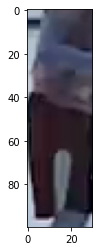

(288, 412, 30, 100)
(289, 415, 30, 100)
(289, 414, 30, 100)
(290, 413, 30, 100)
(290, 403, 30, 100)
(290, 408, 30, 100)
(288, 403, 30, 100)
(288, 408, 30, 100)
(288, 408, 30, 100)
(290, 399, 30, 100)
(285, 397, 30, 100)
(290, 402, 30, 100)
(290, 393, 30, 100)
(293, 394, 30, 100)
(293, 389, 30, 100)
(293, 390, 30, 100)
(293, 384, 30, 100)
(293, 390, 30, 100)
(292, 387, 30, 100)
(292, 389, 30, 100)
(292, 388, 30, 100)
(292, 390, 30, 100)
(290, 384, 30, 100)
(291, 390, 30, 100)
(291, 386, 30, 100)
(291, 389, 30, 100)
(291, 384, 30, 100)
(291, 386, 30, 100)
(290, 385, 30, 100)
(290, 387, 30, 100)
(290, 384, 30, 100)
(290, 387, 30, 100)
(290, 384, 30, 100)
(291, 386, 30, 100)
(291, 383, 30, 100)
(293, 385, 30, 100)
(293, 379, 30, 100)
(293, 379, 30, 100)
(293, 377, 30, 100)
(293, 378, 30, 100)
(293, 375, 30, 100)
(293, 379, 30, 100)
(293, 375, 30, 100)
(293, 376, 30, 100)
(293, 376, 30, 100)
(293, 376, 30, 100)
(293, 380, 30, 100)
(293, 379, 30, 100)
(293, 381, 30, 100)
(292, 381, 30, 100)


In [79]:
import cv2
import numpy as np

video = cv2.VideoCapture("videos/basketball_1.mp4")

_, first_frame = video.read()
x = 290
y = 430
width = 30
height = 100


roi = first_frame[y: y + height, x: x + width]
hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
roi_hist = cv2.calcHist([hsv_roi], [0], None, [180], [0, 180])
roi_hist = cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

plt.imshow(roi)
plt.show()

term_criteria = (cv2.TERM_CRITERIA_COUNT, 5, 1)

while True:
    _, frame = video.read()
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = cv2.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    _, track_window = cv2.meanShift(mask, (x, y, width, height), term_criteria)
    x, y, w, h = track_window
    print(track_window)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imshow("Mask", mask)
    cv2.imshow("Frame", frame)

    key = cv2.waitKey(60)
    if key == 27:
        break

video.release()
cv2.destroyAllWindows()